In [1]:
%matplotlib nbagg

In [2]:
import numpy as np
import strid
import matplotlib.pyplot as plt
import scipy.signal

# Generating data
Let us start by generating some data. Consider a shear frame with 9 floors, the shear frame is damped with Rayleigh damping, defined by 5% in the first and last mode. 

The load (input) consists of:

* Deterministic part: (measured) quadratic sine sweep applied to the top floor which goes from zero to twice the highest natural frequency of the shear frame 
* Stochastic part: (not measured) zero mean independet white process noise applied to all floors

The output is assumed to be accelerations at each floor together with white, zero mean, independent measurement noise.

<IPython.core.display.Javascript object>


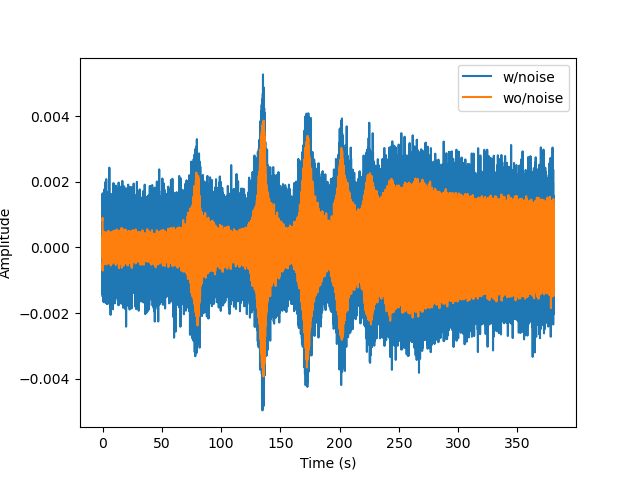

<IPython.core.display.Javascript object>


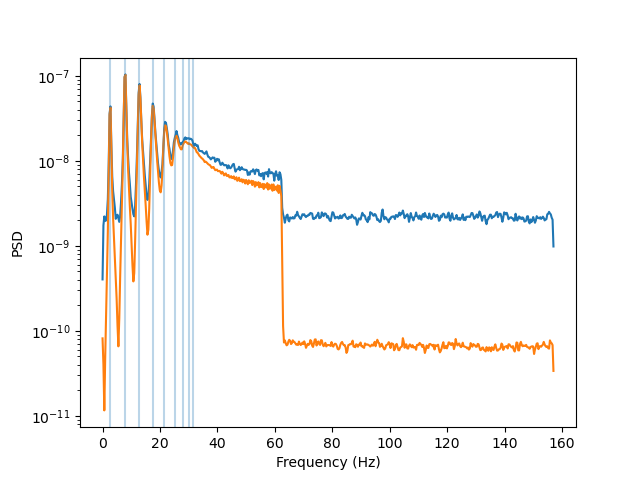

Text(0.5, 0, 'Frequency (Hz)')

In [3]:
# Create a shear frame
sf = strid.utils.ShearFrame(9, 1e3, 1e7)
sf.set_rayleigh_damping_matrix([sf.get_natural_frequency(1), sf.get_natural_frequency(sf.n)], [.05]*2)

# Determine the time discretization and period
Tmax = 1. / strid.w2f(sf.get_natural_frequency(1))
fmax = strid.w2f(sf.get_natural_frequency(sf.n))
T = 1000*Tmax
fs = 10 * fmax
t = np.arange(0., T, 1/fs)

# Define loads on system
## Measured: quadratic sine sweep applied to top floor
u = scipy.signal.chirp(t, 0, T, fmax*2, method='quadratic').reshape(1, -1)

## Unmeasureable: Stochastic loads on all floors (Process noise)
w = np.random.normal(size=(sf.n, t.size)) * 1e-1

## Load matrix, f
F = w.copy()
F[-1] += u[0]

# Simulate response, accelerations at each floor measured
y0, _, _ = sf.simulate(t, F)

# Add measurement noise
v = np.random.normal(size=y0.shape)*y0.std()*1e-0
y = y0 + v

plt.figure("Accelerations measured at top floor")
plt.plot(t, y[-1], label="w/noise")
plt.plot(t, y0[-1], label="wo/noise")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.figure("PSD of accelerations at top floor")
for yi in [y[-1], y0[-1]]:
    freqs, Gyy = scipy.signal.welch(yi, fs, nperseg=2**10)
    plt.semilogy(freqs, Gyy)
    

for n in range(1, 1+sf.n):
    plt.axvline(strid.w2f(sf.get_natural_frequency(n)), alpha=.3)
plt.ylabel('PSD')    
plt.xlabel('Frequency (Hz)')

# System identification

Use the measured outputs $y$ and the measured input $u$ to determine the system properties of the shear frame. First we create a subspace identification instance with the input.

In [4]:
csid = strid.CombinedDeterministicStochasticSID(u, y, fs)

We will use a stabilization diagram to determine the physical modes (poles), first we perform system identification from the data with 25 block rows and model order between 5 and 150 in increments of 5.

In [5]:
modes = {}
for i, order in enumerate(range(5, 100, 1)):
    A, C = csid.perform(order, 25)
    modes[order] = strid.Mode.find_modes_from_ss(A, C, csid.fs) 

and then we plot the identified modes in the stabilization diagram and we pick the stable modes.

<IPython.core.display.Javascript object>


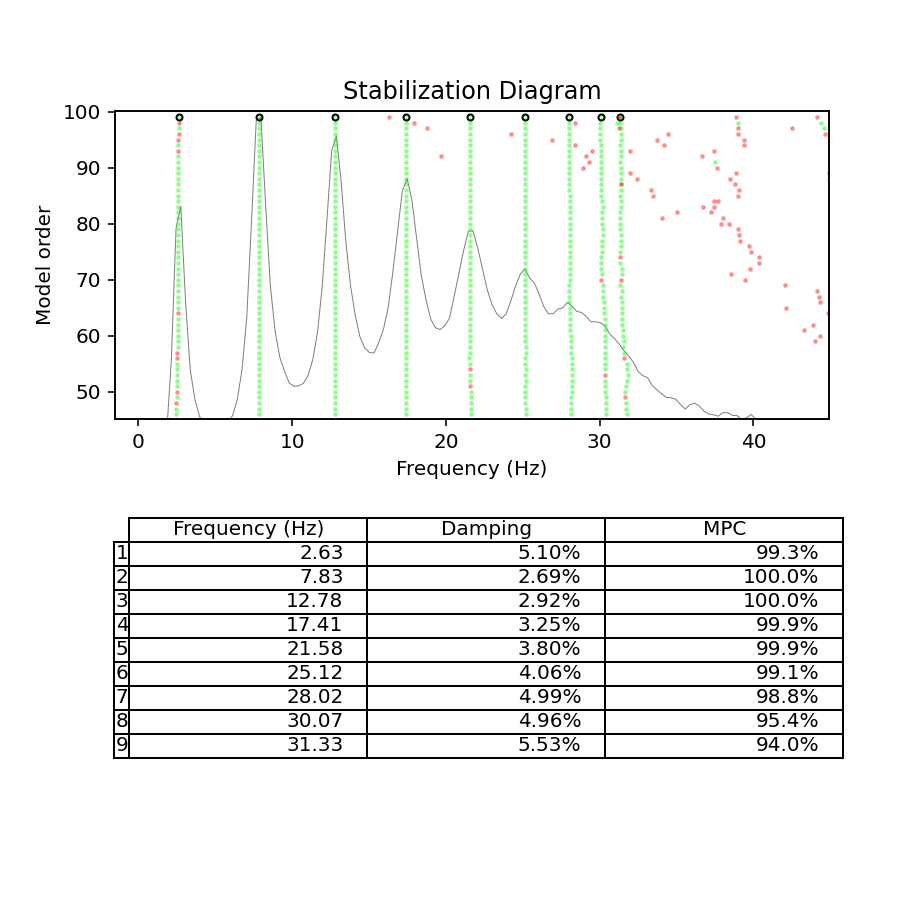

In [6]:
stabdiag = strid.StabilizationDiagram()
stabdiag.plot(modes)
f, psd = csid.psdy(nperseg=2**10)
stabdiag.axes_psd.semilogy(f, np.trace(np.abs(psd)), color=(0., 0., 0., .5), lw=.5)

Finally, we can access the picked modes from the `picked_modes` property of the stabilization diagram object, see below.

In [7]:
modes = stabdiag.picked_modes

# Comparison between estimated and true modes

Below, we compare the identified modes against the exact solution.

<IPython.core.display.Javascript object>


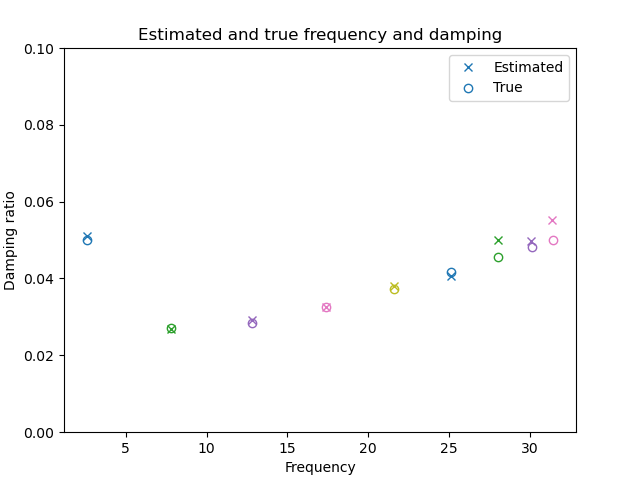

<IPython.core.display.Javascript object>


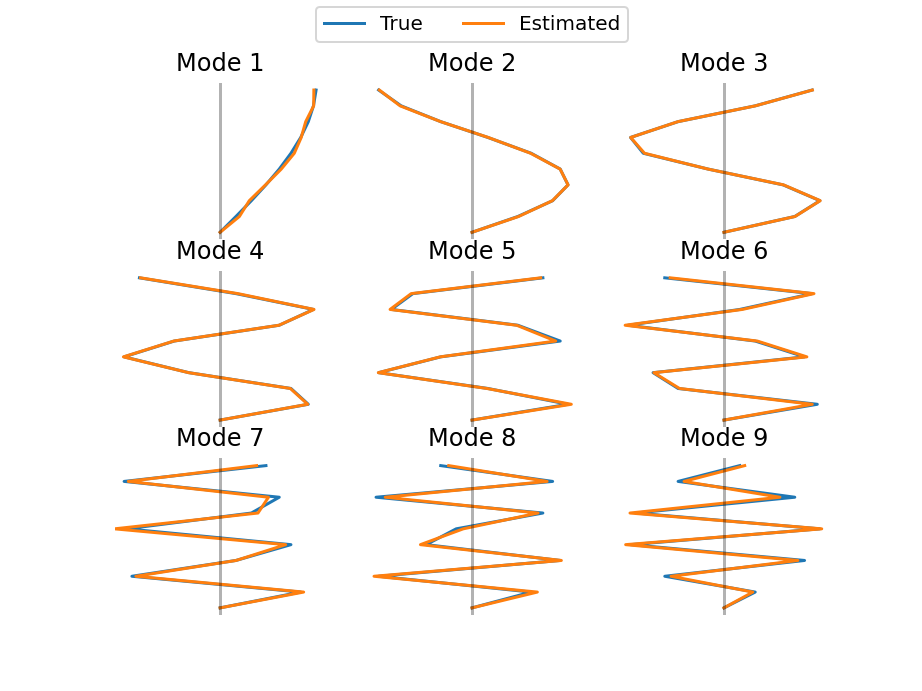

In [8]:
fig = plt.figure("Damping estimate")
axd = fig.add_axes((0.1, 0.1, .8, .8))
axd.set(xlabel='Frequency', ylabel='Damping ratio', title='Estimated and true frequency and damping',
        ylim=(0, .10)
       )
figmodes, axes = plt.subplots(ncols=3, nrows=3, dpi=144)
res = []
for n in range(1, 1+sf.n):
    ax = axes.flatten()[n-1]
    un = sf.get_mode_shape(n)
    fn = strid.w2f(sf.get_natural_frequency(n))
    xin = sf.get_rayleigh_damping_ratio(n)
    nmax = np.argmax([strid.modal_assurance_criterion(mode.v, un) for mode in modes])
    mode = modes[nmax]
    
    line, = axd.plot(mode.f, mode.xi, 'x')
    line, = axd.plot(fn, xin, 'o', mec=line.get_color(), mfc=(0, 0, 0, 0))
    
    
    ferr = (mode.f-fn)/fn * 100
    xierr = (mode.xi-xin)/xin*100
    mac = strid.modal_assurance_criterion(un, mode.v)
    res.append([n, ferr, xierr, mac*100,])
    
    
    v_true = np.r_[0., un]
    v = np.r_[0, mode.v]
    v = strid.modal_scale_factor(v, v_true)*v
    z = np.arange(v.size)
    ax.plot(v_true, z, label='True')
    ax.plot(v.real, z, label='Estimated')
    
    if n == 2:
        ax.legend(bbox_to_anchor=(.5, 1.20), loc='lower center', ncol=2)
        axd.legend(['Estimated', 'True'],)
    ax.axvline(0., color=(0, 0, 0, .3))
    
    ax.set_title(f"Mode {n}")
    ax.axis('off')
    ax.set_xlim(-.5, .5)